In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm 
%matplotlib inline

In [237]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [171]:
def generate_simple_dataset(size, pandas=False):
    h, w = size
    v = np.linspace(0.1, 40000, w)
    
    dataset = v
    for i in range(h-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_2class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 2*np.cos(10*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_3class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 10*np.cos(20*pi*t) + 3*np.cos(20*pi*t) + noise

def get_cosinus_matrix(data_simple):
    data_simple = generate_simple_dataset((128, 20000))
    vec = data_simple[65]
    
    size = (128, 20000)
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    
    data_simple[65] = vec
    
    return data_simple

In [172]:
data = get_cosinus_matrix(data_simple)
ICA = get_ICA()
#Перемножаем ICA и EEG матрицы
matrix = np.matmul(ICA, data)
#Разбиваем на матрицы классов, чтоб проще было делить на семплы
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:data.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1)
sample_calss2 = get_sample(matrix_calss2)
sample_calss3 = get_sample(matrix_calss3)
#Преобразование Фурье
samples_fft = list(map(abs, fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, first_n_elements=20)))

sample_calss1_fft = samples_fft[:34]
sample_calss2_fft = samples_fft[34:34*2]
sample_calss3_fft = samples_fft[34*2:]

#Создание строк для датасета, из матрицы 128*20 -> в вектор 2560
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_1['label'] = 1

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1.loc[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_2['label'] = 2

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2.loc[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((34, 2560)))
data_class_3['label'] = 3

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3.loc[i, :-1] = sample_calss3_fft_str[i]
    
    
data = pd.concat([data_class_1, data_class_2, data_class_3], axis=0)
print(data.shape)

100%|██████████| 34/34 [00:23<00:00,  1.47it/s]

(102, 2561)


In [238]:
#Понизим размерность до 60 компонент
PCA = PCA(n_components=60)

#Стандартизируем матрицу
Scaler = StandardScaler()
data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# Понижаем размерность
data_pca = PCA.fit_transform((data).iloc[:, :-1])

data_pca = pd.DataFrame(data_pca)
# data_pca['label'] = data['label'].values
labels = data['label'].values

#Посмотрим важные признаки с помощью RF
rf = RandomForestClassifier()
rf.fit(data_pca, labels)

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

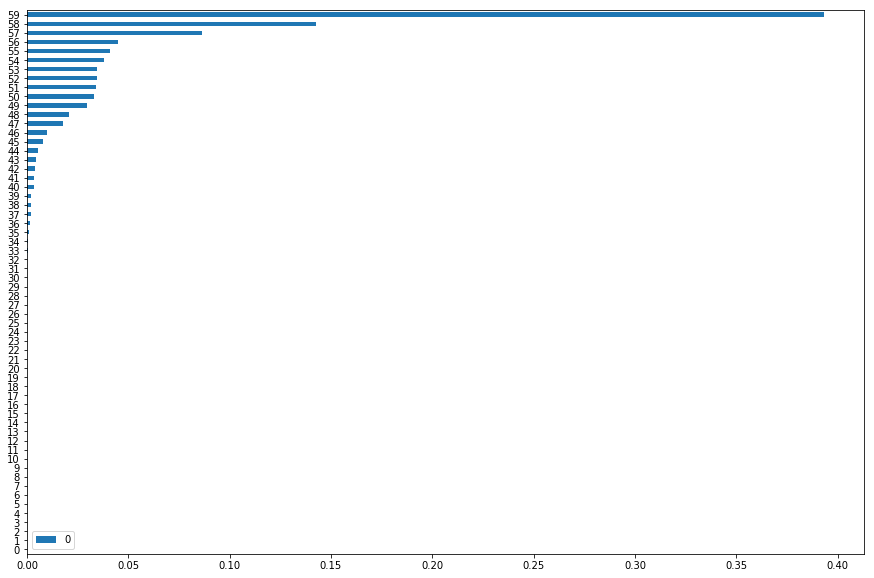

In [239]:
pd.DataFrame(sorted(rf.feature_importances_)).plot(kind='barh', figsize=(15,10))

In [240]:
## Сделаем соответсвие между главными компонентами и исходными признаками
train_features = (data).iloc[:, :-1].values
from sklearn.decomposition import PCA
model = PCA(n_components=60).fit(train_features)
X_pc = model.transform(train_features)

components_easy_trashold = []
for component_number in tqdm(range(60)):
    trashold = np.mean(abs(model.components_[component_number]))/10
    features_in_component = []
    
    for idx, value in enumerate(model.components_[component_number]):
        if abs(value) > trashold:
            features_in_component.append(idx)
    components_easy_trashold.append(features_in_component)

100%|██████████| 60/60 [00:00<00:00, 519.18it/s]


In [241]:
components_hard_trashold = []
for component_number in tqdm(range(60)):
    trashold = np.max(abs(model.components_[component_number])) - 0.2
    features_in_component = []
    
    for idx, value in enumerate(model.components_[component_number]):
        if abs(value) > trashold:
            features_in_component.append(idx)
    components_hard_trashold.append(features_in_component)

100%|██████████| 60/60 [00:00<00:00, 700.69it/s]


In [242]:
# Получим соответсвие компонент и важных для них признаков, по заданному трешхолду

for component_number, i in enumerate(components_hard_trashold):
    if component_number > 57:
        print('component_number:', component_number, 'features:', i)
        print()

component_number: 58 features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 137, 138, 140, 141, 142, 143, 145, 146, 148, 150, 151, 153, 155, 156, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 176, 177, 178, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 216, 219, 220, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 2

In [243]:
## Возьмем Топ-5 компонент и пересечем их по признакам (по жесткому трешхолду)


top_5 = set(components_hard_trashold[-1]) & set(components_hard_trashold[-2]) & set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])
print(top_5)

{3, 4, 7, 8, 11, 12, 17, 20, 21, 27, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 53, 58, 62, 63, 67, 68, 69, 73, 74, 77, 79, 80, 81, 82, 87, 90, 96, 98, 99, 103, 105, 109, 110, 115, 116, 117, 119, 120, 127}


In [244]:
## Возьмем Топ-4 компонент и пересечем их по признакам
top_4 = set(components_hard_trashold[-2]) & set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])

In [245]:
## Возьмем Топ-3 компонент и пересечем их по признакам
top_3 = set(components_hard_trashold[-3]) & \
set(components_hard_trashold[-4]) & set(components_hard_trashold[-5])

In [246]:
## Теперь возьмем худшие 3 компоненты, которые по мнению RF
## абсолютно не вносят вклад в модель и вычтим множетсва лучших из множетсва худших.
## Тогда у нас должны остаться по настоящему важные признаки

bad_components = []
for i in components_hard_trashold[:2]:
    for j in i:
        bad_components.append(j)

bad_components = set(bad_components)

len(bad_components)

2560

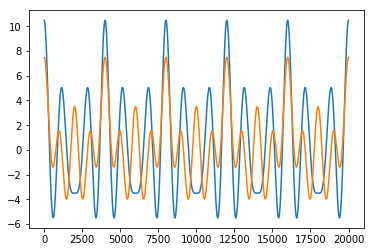

In [80]:
plt.plot(2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise)
plt.plot(2*np.cos(5*pi*t) + 2*np.cos(10*pi*t) + 3*np.cos(20*pi*t) + noise)

In [71]:
x = np.linspace(0, 100, num=1000)
x1 = np.linspace(0, 10, num=1000)
x2 = np.linspace(0, 1000, num=1000)

In [20]:
x

array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029029 ,   3.003003  ,   3.1031031 ,
         3.2032032 ,   3.3033033 ,   3.4034034 ,   3.5035035 ,
         3.6036036 ,   3.7037037 ,   3.8038038 ,   3.9039039 ,
         4.004004  ,   4.1041041 ,   4.2042042 ,   4.3043043 ,
         4.4044044 ,   4.5045045 ,   4.6046046 ,   4.7047047 ,
         4.8048048 ,   4.9049049 ,   5.00500501,   5.10510511,
         5.20520521,   5.30530531,   5.40540541,   5.50550551,
         5.60560561,   5.70570571,   5.80580581,   5.90590591,
         6.00600601,   6.10610611,   6.20620621,   6.30

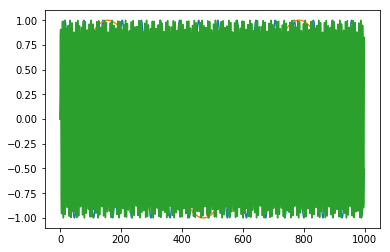

In [25]:
plt.plot(np.sin(x))
plt.plot(np.sin(x1))
plt.plot(np.sin(x2))